In [7]:
import os
import time
import pkg_resources
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

In [8]:
##geometry.py
def setgeometry(q):
    global qdim, xmin, xmax, xstops, xmid, xwid

    # bins
    qdim = q

    # prior range for x (will be uniform)
    xmin, xmax = 0, 1

    # definition of quantization bins
    xstops = np.linspace(xmin, xmax, qdim + 1)

    # to plot histograms
    xmid = 0.5 * (xstops[:-1] + xstops[1:])
    xwid = xstops[1] - xstops[0]

setgeometry(64)

In [9]:
##network.py
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim


def makenet(dims, softmax=True, single=True):
  """Make a fully connected DNN with layer widths described by `dims`.
  CUDA is always enabled, and double precision is set with `single=False`.
  The output layer applies a softmax transformation,
  disabled by setting `softmax=False`."""

  ndims = len(dims)

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # the weights must be set explicitly as attributes in the class
      # (i.e., we can't collect them in a single list)
      for l in range(ndims - 1):
        layer = nn.Linear(dims[l], dims[l+1])
        
        if not single:
          layer = layer.double()
        
        if torch.cuda.is_available():
          layer = layer.cuda()
        
        setattr(self, f'fc{l}', layer)
                
    def forward(self, x):
      # per Alvin's recipe, apply relu everywhere but last layer
      for l in range(ndims - 2):
        x = F.leaky_relu(getattr(self, f'fc{l}')(x), negative_slope=0.2)

      x = getattr(self, f'fc{ndims - 2}')(x)

      if softmax:
        return F.softmax(x, dim=1)
      else:
        return x
  
  return Net


def makenetbn(dims, softmax=True, single=True):
  """A batch-normalizing version of makenet. Experimental."""

  ndims = len(dims)

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # the weights must be set explicitly as attributes in the class
      # (i.e., we can't collect them in a single list)
      for l in range(ndims - 1):
        layer = nn.Linear(dims[l], dims[l+1])
        bn = nn.BatchNorm1d(num_features=dims[l+1])
        
        if not single:
          layer = layer.double()
          bn = bn.double()
        
        if torch.cuda.is_available():
          layer = layer.cuda()
          bn = bn.cuda()
        
        setattr(self, f'fc{l}', layer)
        setattr(self, f'bn{l}', bn)
                
    def forward(self, x):
      # per Alvin's recipe, apply relu everywhere but last layer
      for l in range(ndims - 2):
        x = getattr(self, f'bn{l}')(F.leaky_relu(getattr(self, f'fc{l}')(x), negative_slope=0.2))

      x = getattr(self, f'fc{ndims - 2}')(x)

      if softmax:
        return F.softmax(x, dim=1)
      else:
        return x
  
  return Net

In [10]:
def numpy2cuda(array, single=True):
  array = torch.from_numpy(array)
  
  if single:
    array = array.float()
    
  if torch.cuda.is_available():
    array = array.cuda()
    
  return array


def cuda2numpy(tensor):
  return tensor.detach().cpu().numpy()

In [11]:
from GWFunctions_v3 import h_func_f2
def syntrain(size,  region=[[0.4, 0.6], [7*np.pi/4, 2*np.pi]], varx='theta_N', 
             varall=True, seed=None, single=True, noise=1):
    """Makes a training set using the ROMAN NN. It returns labels (for `varx`,
        or for all if `varall=True`), indicator vectors, and ROM coefficients
        (with `snr` and `noise`). Note that the coefficients are kept on the GPU.
        Parameters are sampled randomly within `region`."""
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
    
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    with torch.no_grad():
        xs = torch.zeros((size,2), dtype=torch.float, device=device)

        for i, r in enumerate(region):
            xs[:,i] = r[0] + (r[1] - r[0]) * torch.rand((size,), dtype=torch.float, device=device)
        
        xs_1 = xs.detach().cpu().double().numpy()
        
        #generating signals
        signal = np.apply_along_axis(h_func_f2, 1, xs_1, noise)[:,:,0]
            
        signal_r, signal_i = numpy2cuda(signal.real), numpy2cuda(signal.imag)
        
        #setting up real and imag alphas
        alphas = torch.zeros((size, 200*2), dtype=torch.float if single else torch.double, device=device)
        
        alphas[:,0::2] = signal_r 
        alphas[:,1::2] = signal_i 

    xr = xs.detach().cpu().double().numpy()

    del xs, signal_r, signal_i

      # normalize (for provided regions)
    for i, r in enumerate(region):
        xr[:,i] = (xr[:,i] - r[0]) / (r[1] - r[0])

    if isinstance(varx, list):
        ix = ['theta_N','phi'].index(varx[0])
        jx = ['theta_N','phi'].index(varx[1])    

        i = np.digitize(xr[:,ix], xstops, False) - 1
        i[i == -1] = 0; i[i == qdim] = qdim - 1
        px = np.zeros((size, qdim), 'd'); px[range(size), i] = 1

        j = np.digitize(xr[:,jx], xstops, False) - 1
        j[j == -1] = 0; j[j == qdim] = qdim - 1
        py = np.zeros((size, qdim), 'd'); py[range(size), j] = 1

        if varall:
            return xr, np.einsum('ij,ik->ijk', px, py), alphas
        else:
            return xr[:,[ix,jx]], np.einsum('ij,ik->ijk', px, py), alphas    
    else:
        ix = ['theta_N','phi'].index(varx)

        i = np.digitize(xr[:,ix], xstops, False) - 1
        i[i == -1] = 0; i[i == qdim] = qdim - 1
        px = np.zeros((size, qdim), 'd'); px[range(size), i] = 1

        if varall:
            return xr, px, alphas
        else:
            return xr[:,ix], px, alphas

In [12]:
def syntrainer(net, syntrain, lossfunction=None, iterations=300, 
               batchsize=None, initstep=1e-3, finalv=1e-5, clipgradient=None, validation=None,
               seed=None, single=True):
  """Trains network NN against training sets obtained from `syntrain`,
  iterating at most `iterations`; stops if the derivative of loss
  (averaged over 20 epochs) becomes less than `finalv`."""

  if seed is not None:
    np.random.seed(seed)
    torch.manual_seed(seed)

  indicatorloss = 'l' in lossfunction.__annotations__ and lossfunction.__annotations__['l'] == 'indicator'  
  
  if validation is not None:
    raise NotImplementedError
    
    vlabels = numpy2cuda(validation[1] if indicatorloss else validation[0], single)
    vinputs = numpy2cuda(validation[2], single)
  
  optimizer = optim.Adam(net.parameters(), lr=initstep)

  training_loss, validation_loss = [], []
  
  for epoch in range(iterations):
    t0 = time.time()

    xtrue, indicator, inputs = syntrain()
    labels = numpy2cuda(indicator if indicatorloss else xtrue, single)

    if batchsize is None:
      batchsize = inputs.shape[0]
    batches = inputs.shape[0] // batchsize

    averaged_loss = 0.0    
    
    for i in range(batches):
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs[i*batchsize:(i+1)*batchsize])
      loss = lossfunction(outputs, labels[i*batchsize:(i+1)*batchsize])
      loss.backward()
      
      if clipgradient is not None:
        torch.nn.utils.clip_grad_norm_(net.parameters(), clipgradient)
      
      optimizer.step()

      # print statistics
      averaged_loss += loss.item()

    training_loss.append(averaged_loss/batches)

    if validation is not None:
      loss = lossfunction(net(vinputs), vlabels)
      validation_loss.append(loss.detach().cpu().item())

    if epoch == 1:
      print("One epoch = {:.1f} seconds.".format(time.time() - t0))

    if epoch % 50 == 0:
      print(epoch,training_loss[-1],validation_loss[-1] if validation is not None else '')

    try:
      if len(training_loss) > iterations/10:
        training_rate = np.polyfit(range(20), training_loss[-20:], deg=1)[0]
        if training_rate < 0 and training_rate > -finalv:
          print(f"Terminating at epoch {epoch} because training loss stopped improving sufficiently: rate = {training_rate}")
          break

      if len(validation_loss) > iterations/10:
        validation_rate = np.polyfit(range(20), validation_loss[-20:], deg=1)[0]        
        if validation_rate > 0:
          print(f"Terminating at epoch {epoch} because validation loss started worsening: rate = {validation_rate}")
          break
    except:
      pass
          
  print("Final",training_loss[-1],validation_loss[-1] if validation is not None else '')
      
  if hasattr(net,'steps'):
    net.steps += iterations
  else:
    net.steps = iterations

In [13]:
dimensions = [200*2] + [1024]*8 + [1*6]
percival_network = makenet(dimensions, softmax=False)
network_to_use = percival_network()

In [14]:
#load the network
network_to_use.load_state_dict(torch.load('/content/theta-phi_l200-1024x8_2d_5000it.pt'))
network_to_use.eval()

<bound method Module.eval of Net(
  (fc0): Linear(in_features=400, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  (fc8): Linear(in_features=1024, out_features=6, bias=True)
)>

In [15]:
mutest = syntrain(5000)
theta_N = mutest[0][:,0]
phi = mutest[0][:,1]
idx = np.argsort(theta_N)

In [16]:
def synlike(a, syntrain, iterations=1000000):
  with torch.no_grad():
    # note aimag defined with plus here, exp below modified consistently
    # [areal] = [aimag] = nbasis x nsignals 
    areal, aimag = torch.t(a[:,0::2]), torch.t(a[:,1::2])

    # [anorm] = nsignals
    anorm = torch.sum(areal*areal + aimag*aimag, dim=0)
    
    cnt, norm, like = 0, 0, 0
    adapt = None
    while cnt < iterations:
      # [pxt] = nbatch x qdim
      _, pxt, alpha = syntrain()
      cnt = cnt + alpha.shape[0]

      # cpxt = torch.from_numpy(pxt).cuda()
      # handle 2D indicator array (assume square qdim)
      cpxt = numpy2cuda(pxt if pxt.ndim == 2 else pxt.reshape((pxt.shape[0], pxt.shape[1]*pxt.shape[1])),
                        alpha.dtype == torch.float32)
      
      # [alphareal] = [alphaimag] = nbatch x nbasis
      alphareal, alphaimag = alpha[:,0::2], alpha[:,1::2]

      # [norm] = qdim
      norm += torch.sum(cpxt, dim=0)
      
      # [alphanorm] = nbatch
      alphanorm = torch.sum(alphareal*alphareal + alphaimag*alphaimag, dim=1)

      # automatic normalization of exponentials based on the first batch
      loglike = (alphareal @ areal + alphaimag @ aimag - 0.5*alphanorm.unsqueeze(1) - 0.5*anorm)*1/100000
      if adapt is None:
        adapt = torch.max(loglike, dim=0)[0]
      loglike -= adapt

      # [like] = qdim x nsignals = (qdim x nbatch) @ [(nbatch x nbasis) @ (nbasis x nsignals) + (nbatch x 1) + nsignals]
      # remember broadcasting tries to match the last dimension [so A @ b = sum(A * b,axis=1)]
      like += torch.t(cpxt) @ torch.exp(loglike)

    # (qdim x nsignals) * (qdim x 1)
    like = like / norm.unsqueeze(1)  
    
    # [ret] = nsignals x qdim = (nsignals x qdim) * qdim
    ret = torch.t(like / torch.sum(like, dim=0))
    
    nret = ret.detach().cpu().numpy()
    
  return nret if pxt.ndim == 2 else nret.reshape((nret.shape[0], pxt.shape[1], pxt.shape[1]))

In [24]:
likeset_theta_N = lambda: syntrain(size=100000, varx='theta_N', region=[[0.4, 0.6], [7*np.pi/4, 2*np.pi]], noise=0)
likeset_phi = lambda: syntrain(size=100000, varx='phi', region=[[0.4, 0.6], [7*np.pi/4, 2*np.pi]], noise=0)
likeset_2 = lambda: syntrain(size=10000, varx=['theta_N','phi'], region=[[0.4, 0.6], [7*np.pi/4, 2*np.pi]], noise=0)

In [ ]:
%%time
sl_theta_N = synlike(mutest[2][:24,:], likeset_theta_N, iterations=10000000)

In [19]:
%%time
sl_phi = synlike(mutest[2][:24,:], likeset_phi, iterations=10000000)

CPU times: user 12min 33s, sys: 7.27 s, total: 12min 40s
Wall time: 12min 33s


In [20]:
import matplotlib.pyplot as pp
def plotgauss(xtrue, indicator, inputs, net=None, like=None, varx=None, twodim=False, istart=0, single=True):  
  pp.figure(figsize=(12,8))

  if isinstance(like, types.FunctionType):
    like = like(inputs)

  for i in range(6):
    pp.subplot(3,2,i+1)

    # make and plot Gaussian mixture
    
    netinput = inputs[istart+i:(istart+i+1),:]
    with torch.no_grad():
      pars = net(netinput).detach().cpu().numpy().flatten()
    
    if twodim:
      Fxx, Fyy = pars[1::6]**2, pars[3::6]**2
      Fxy = np.arctan(pars[4::6]) / (0.5*math.pi) * pars[1::6] * pars[3::6]
      weight = torch.softmax(torch.from_numpy(pars[5::6]),dim=0).numpy()

      dx  = (pars[2::6] if varx == 'phi' else pars[0::6]) - xmid[:,np.newaxis]
      Cxx = Fxx / (Fxx*Fyy - Fxy*Fxy) if varx == 'phi' else Fyy / (Fxx*Fyy - Fxy*Fxy) 

      pdf = np.sum(weight * np.exp(-0.5*dx**2/Cxx) / np.sqrt(2*math.pi*Cxx) * xwid, axis=1)

      # logmod = scs.logsumexp(np.log(weight) - 0.5*(Fxx*dx*dx + Fyy*dy*dy + 2*Fxy*dx*dy) + 0.5*np.log(Fxx*Fyy - Fxy*Fxy), axis=2)
    else:
      if len(pars) == 2:
        pdf = np.exp(-0.5*(xmid - pars[0])**2/pars[1]**2) / math.sqrt(2*math.pi*pars[1]**2) * xwid
      else:
        wg = torch.softmax(torch.from_numpy(pars[2::3]), dim=0).numpy()
        pdf = np.sum(wg * np.exp(-0.5*(xmid[:,np.newaxis] - pars[0::3])**2/pars[1::3]**2) / np.sqrt(2*math.pi*pars[1::3]**2) * xwid, axis=1)
    
    pp.plot(xmid, pdf, color='C0')
    
    # plot likelihood
    pp.plot(xmid, like[istart+i], color='C1')

    # show true x
    if xtrue.ndim == 2:
      ix = ['theta_N', 'phi'].index(varx)
      pp.axvline(xtrue[istart+i, ix], color='C2', ls=':')
    else:
      pp.axvline(xtrue[istart+i], color='C2', ls=':')

In [21]:
def netmeanGn(inputs, net=None, single=True):
  if isinstance(inputs, np.ndarray):
    inputs = numpy2cuda(inputs, single)
    
  pars = cuda2numpy(net(inputs))

  dx  = pars[:,0::3] 
  std = pars[:,1::3]
  pweight = torch.softmax(torch.from_numpy(pars[:,2::3]),dim=1).numpy()

  # see https://en.wikipedia.org/wiki/Mixture_distribution
  xmean = np.sum(pweight * dx, axis=1)
  xerr  = np.sqrt(np.sum(pweight * (dx**2 + std**2), axis=1) - xmean**2)

  return xmean, xerr

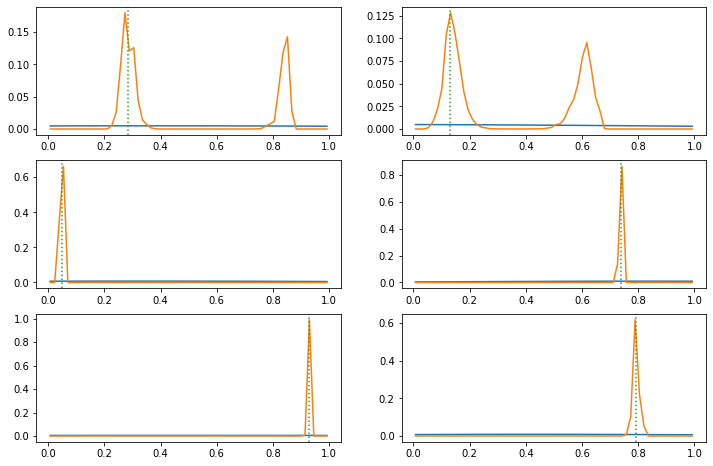

In [22]:
import types
plotgauss(*mutest, net=network_to_use, varx='theta_N', like=sl_theta_N, twodim=True, istart=6)

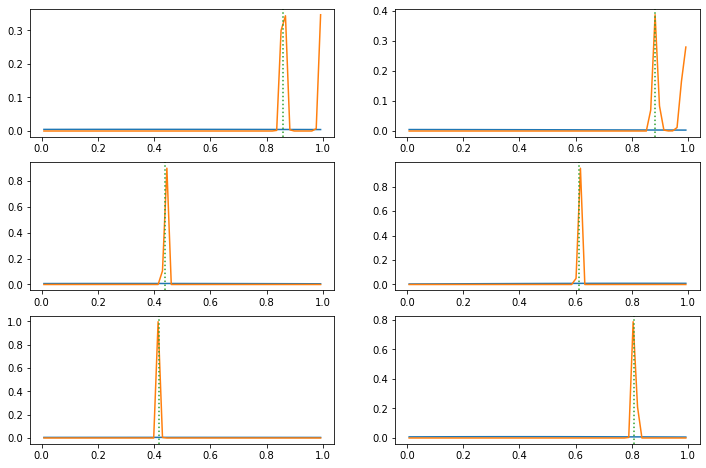

In [23]:
plotgauss(*mutest, net=network_to_use, varx='phi', like=sl_phi, twodim=True, istart=6)